In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree as Tree;

In [2]:
image_folder_path = "C:/Users/louis/github_vs/113_data/"

years = os.listdir(image_folder_path)
post_chat = years[5]
pre_chat = years[6]
years = years[0:5]
print(years)

['2017', '2018', '2019', '2020', '2021']


In [135]:
# retrieving the message info data
df_all = pd.DataFrame(columns =['event_id', 'message_id', 'user_handle', 'sec_since_start']);
for y in years:
    
    events =  os.listdir(image_folder_path+y)

    for e in events:
        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"message_info.tsv",sep= '\t')
        df_all = df_all.merge(df, how = "outer")
        
df_all["id"] = df_all["event_id"].astype("string") + df_all["message_id"].astype("string")
df_all=df_all.set_index("id")
# group by the messages by conversation
df_group = df_all.groupby("event_id")

df_all.drop(['event_id','message_id'],axis=1,inplace=True)
df_all

,user_handle,sec_since_start
id,,
cl0709090,system_1,0.0
cl0709091,employee03119,9.0
cl0709092,client,44.0
cl0709093,employee03119,64.0
cl0709094,system_8,70.0
...,...,...
cl0020693,system_7,20.0
cl0020694,employee00008,25.0
cl0020695,client,77.0


In [162]:
# combining the message info data with the CDS data
users = [x for x in df_all["user_handle"].unique()]
users_dict_cdstot = dict.fromkeys(users, 0) # total CDS used per user (there are different employees e.g.02,03)
users_dict_convtot = dict.fromkeys(users, 0) # total conversations a user has participated in

for y in years:
    print("year =",y)
    events =  os.listdir(image_folder_path+y)

    for e in events:

        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"CDS_results.tsv",sep= '\t')
        df["id"] = df["event_id"].astype("string") + df["message_id"].astype("string")
        df=df.set_index("id")
        dm = df.join(df_all)
        dm.drop(['message_id','sec_since_start'],axis=1,inplace=True)
        dm_user = dm.groupby("user_handle")
        for name, group in dm_user:
            users_dict_convtot[name] = users_dict_convtot[name]+ group["event_id"].nunique()  
            group.drop(['user_handle',"event_id"],axis=1,inplace=True)
            users_dict_cdstot[name] = users_dict_cdstot[name]+ group.sum().values.sum()  
    print("-------------------------------------------------------")


year = 2017
-------------------------------------------------------
year = 2018
-------------------------------------------------------
year = 2019
-------------------------------------------------------
year = 2020
-------------------------------------------------------
year = 2021
-------------------------------------------------------


In [186]:
cdstot= []
convtot =[]
for user in users:
    if 'employee' in user:
        cdstot.append(users_dict_cdstot[user])
        convtot.append(users_dict_convtot[user])

# the correlation between the number of messages a user has sent and the number of conversations it has participated in
np.corrcoef(cdstot, convtot)

array([[1.        , 0.94885557],
       [0.94885557, 1.        ]])

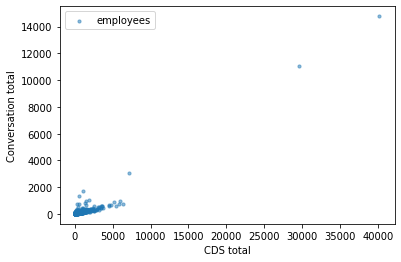

In [188]:
# plotting the relation total conversation- total messages
tot = tuple(zip(cdstot,convtot))

plt.scatter(*zip(*tot), s=10, alpha=0.5, label='employees')
plt.xlabel("CDS total")
plt.ylabel("Conversation total")
plt.legend()

In [159]:
systems =[]
employees = []
for key in users_dict_cdstot.keys():
    if 'system' in key:
        systems.append(users_dict_cdstot[key]) 
    elif 'employee' in key:
        employees.append(users_dict_cdstot[key])
    else:
        print(key)

client


In [160]:
# number of different system users, e.g. system02, 03
print(sum(systems))

47.0


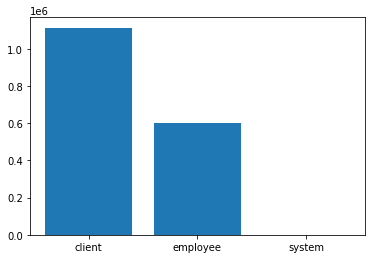

In [153]:
# total number of CDS per user category
plt.bar(height=[users_dict_cdstot['client'],sum(employees),sum(systems)],x=['client','employee','system'])


3212


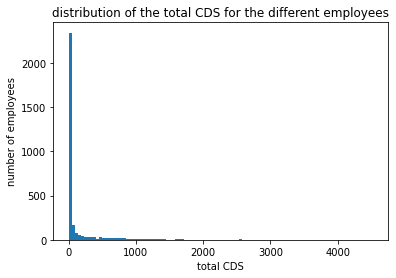

In [156]:
# distribution of total CDS per employee user
nb = 10
employees_shorted = sorted(employees)[nb:len(employees)-nb]

plt.hist(employees_shorted, bins=100, label='employees')
plt.title("distribution of the total CDS for the different employees")
plt.xlabel("total CDS")
plt.ylabel("number of employees")
print(len(employees))

8


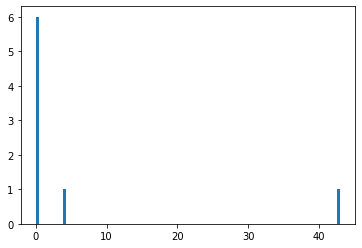

In [157]:
# distribution of total CDS per system user
plt.hist(sorted(systems), bins=100, label='systems')
print(len(systems))

In [5]:
# grouping the total CDS into time bins, to see the distribution of CDS over time
df_cds_per_time = pd.DataFrame(columns =['sec_since_start_norm','sum']);

bins_nb = 100
bins = np.linspace(0, 1, bins_nb)

all_sums_client = np.zeros(bins_nb)
all_sums_sytem = np.zeros(bins_nb)
all_sums_employee = np.zeros(bins_nb)

for y in years:
    print("year =",y)
    events =  os.listdir(image_folder_path+y)

    for e in events:
    # do stuff here for all the years and events. Unfortunately, the data is too heavy to be put in the same df

        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"CDS_results.tsv",sep= '\t')
        df["id"] = df["event_id"].astype("string") + df["message_id"].astype("string")
        df=df.set_index("id")
        # df.drop(['event_id','message_id'],axis=1,inplace=True)
        
        dm = df.join(df_all)
        max = dm.groupby("event_id").transform("max")
        new_df = pd.DataFrame(columns =['sec_since_start_norm','sum'])
        new_df['sum'] = dm.drop(['event_id','message_id','user_handle','sec_since_start'],axis=1).sum(axis = 1) # sum for all the CDS columns
        new_df['sec_since_start_norm'] = dm['sec_since_start']/max['sec_since_start'] # normalize the time by the conversation length
        new_df['user_handle'] = dm['user_handle']
        groups = new_df.groupby(np.digitize(new_df.sec_since_start_norm, bins)) # grouping per time bin
        for time, group in groups:
            time = time-1
            for name, user_group in group.groupby("user_handle"):
                user_group.drop(['user_handle','sec_since_start_norm'],axis=1,inplace=True)
                sums = user_group.sum()['sum'] # cumulative sum of the CDS per time bin
                if 'system' in name:  all_sums_sytem[time] = all_sums_sytem[time] + sums # summing with the previous data folders
                if 'client' in name:  all_sums_client[time] = all_sums_client[time] + sums # summing with the previous data folders
                if 'employee' in name: all_sums_employee[time] = all_sums_employee[time] + sums # summing with the previous data folders

    print("-------------------------------------------------------")


Text(0, 0.5, 'number of CDS')

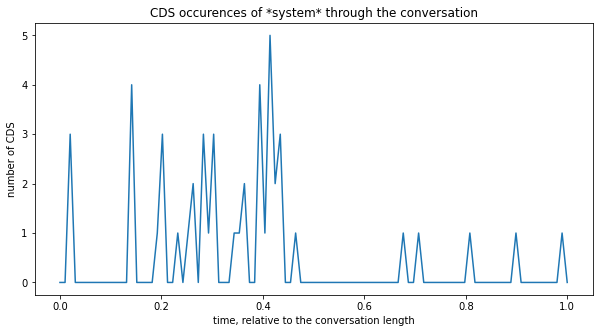

In [134]:
plt.figure(figsize=(10,5))
plt.title("CDS occurences of *system* through the conversation")
plt.plot(bins, all_sums_sytem)
plt.xlabel('time, relative to the conversation length')
plt.ylabel('number of CDS')


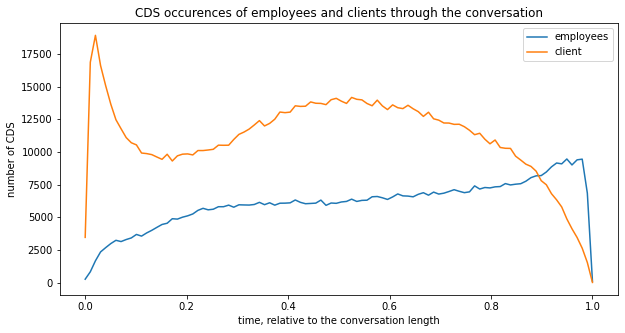

In [161]:
plt.figure(figsize=(10,5))
plt.title("CDS occurences of employees and clients through the conversation")
plt.plot(bins, all_sums_employee, label='employees')
plt.plot(bins, all_sums_client, label='client')
plt.xlabel('time, relative to the conversation length')
plt.ylabel('number of CDS')
plt.legend()

In [3]:
df = pd.read_csv(image_folder_path+years[4]+'/'+"202101"+'/'+"CDS_results.tsv",sep= '\t')
cds_names =df.columns[2:].to_list()
cds_type_nb = len(cds_names)
common_cds = ['hij zal( .+ | )niet denken', 'w(ij|e) zullen( .+ | )weten', 'een onbekwa(am|me)', 'w(ij|e) zullen( .+ | )niet geloven', 'een niet geliefd', 'zwart-/wit', 'w(ij|e) zullen( .+ | )niet weten', 'w(ij|e) zullen( .+ | )niet denken', 'zal( .+ | )verkeerd gaan', 'j(ij|e) (zal|zult)( .+ | )niet weten', 'j(ij|e) (zal|zult)( .+ | )niet denken', 'zal onmogelijk zijn', '(zal|gaat) niet plaatsvinden', 'wordt vreselijk', 'zal vreselijk zijn', 'wordt verschrikkelijk', 'zal verschrikkelijk zijn', 'wordt een ramp', 'zal( .+ | )een ramp zijn', '(zal|gaat) nooit eindigen', 'we zullen( .+ | ) niet', 'j(ij|e) (zal|zult)( .+ | ) niet', 'w(ij|e) zullen( .+ | )geloven', 'z(ij|e) zullen( .+ | )niet denken', 'z(ij|e) zullen( .+ | ) niet', 'afdoende,? maar', 'iedereen zal( .+ | )geloven', 'hij zal( .+ | )niet geloven', 'hij zal( .+ | )geloven', 'ik zie slechts', 'hij zal( .+ | )niet weten', 'zal( .+ | )mis gaan', 'eindigt niet', 'acceptabel,? maar', 'z(ij|e) zal( .+ | )niet denken', 'alleen het (aller)?ergste', 'alleen het slechtste', 'w(ij|e) zullen( .+ | )denken', 'j(ij|e) (zal|zult)( .+ | )niet geloven', 'ik veroorzaakte', 'z(ij|e) zal( .+ | )niet weten', 'wordt onmogelijk', '(zal|gaat) niet ophouden', 'j(ij|e) (zal|zult)( .+ | )geloven', 'ik zal( .+ | ) niet', 'een incompetente?', 'z(ij|e) zullen( .+ | )niet weten', 'z(ij|e) zal( .+ | )niet geloven', 'iedereen zal( .+ | )weten', 'een beschadigde?', 'zal( .+ | )fout gaan', 'iedereen zal( .+ | )denken', '(zal|gaat) niet stoppen', 'waardeloos in', 'een volslagen', 'zwart of wit', 'geef mij de schuld', 'z(ij|e) zullen( .+ | )niet geloven', 'z(ij|e) zal( .+ | )geloven', 'een toxische?', 'hij zal( .+ | )weten', '(zal|gaat) nooit stoppen', 'alleen het (slechte|verkeerde)', 'een ongewenste?', 'niemand zal( .+ | )denken', 'niemand zal( .+ | )weten', 'j(ij|e) (zal|zult)( .+ | )weten', 'een giftige?', 'z(ij|e) zullen( .+ | )geloven', 'iedereen gelooft', 'w(ij|e) geloven( .+ | )niet', 'een hulpelo(os|ze)', 'z(ij|e) zal( .+ | )weten', 'het enige (w|d)at ik zie', 'ik ben verantwoordelijk', 'niemand zal( .+ | )geloven', 'hij zal( .+ | )denken', 'een absolu(ut|te)', 'z(ij|e) zal( .+ | )denken', 'irrelevant', 'een afschuwelijke?', 'gebeurt (elke|iedere) keer', 'mij de schuld geven', 'w(ij|e) geloven', 'niet echt top', 'niet echt geweldig', 'z(ij|e) zullen( .+ | )weten', '(een )?ongeliefde?', 'een kapotte', '(he|al)lemaal door mij', 'top,? maar', 'voelt nog steeds', 'telt niet', 'niemand denkt', 'gaat wel,? maar', 'ik voel m(ij|e) verantwoordelijk', 'hij gelooft( .+ | )niet', 'z(ij|e) zullen( .+ | )denken', 'gebeurt altijd', 'geweldig,? maar', 'een lelijke?', 'z(e|ij) zijn een']

In [136]:
df_cds_per_time = pd.DataFrame(columns =['sec_since_start_norm','sum']);

bins_nb = 100
bins = np.linspace(0, 1, bins_nb)

all_sums_client = np.zeros((bins_nb,cds_type_nb))
all_sums_employee = np.zeros((bins_nb,cds_type_nb))

for y in years:
    print("year =",y)
    events =  os.listdir(image_folder_path+y)

    for e in events:

        df = pd.read_csv(image_folder_path+y+'/'+e+'/'+"CDS_results.tsv",sep= '\t')

        df["id"] = df["event_id"].astype("string") + df["message_id"].astype("string")
        df=df.set_index("id")
        # df.drop(['event_id','message_id'],axis=1,inplace=True)
        
        dm = df.join(df_all)
        max = dm.groupby("event_id").transform("max")
        new_df = dm.drop(['event_id','message_id','user_handle','sec_since_start'],axis=1)
        new_df['sec_since_start_norm'] = dm['sec_since_start']/max['sec_since_start'] # normalize the time by the conversation length
        new_df['user_handle'] = dm['user_handle']
        groups = new_df.groupby(np.digitize(new_df.sec_since_start_norm, bins)) # grouping per time bin
        for time, group in groups:
            time = time-1
            for name, user_group in group.groupby("user_handle"):
                user_group.drop(['user_handle','sec_since_start_norm'],axis=1,inplace=True)
                sums = np.array(user_group.sum(),dtype=np.float64) # cumulative sum of the CDS per time bin
                if 'client' in name:  all_sums_client[time] = all_sums_client[time] + sums # summing with the previous data folders
                if 'employee' in name: all_sums_employee[time] = all_sums_employee[time] + sums # summing with the previous data folders

    print("-------------------------------------------------------")

year = 2017
-------------------------------------------------------
year = 2018
-------------------------------------------------------
year = 2019
-------------------------------------------------------
year = 2020
-------------------------------------------------------
year = 2021
-------------------------------------------------------


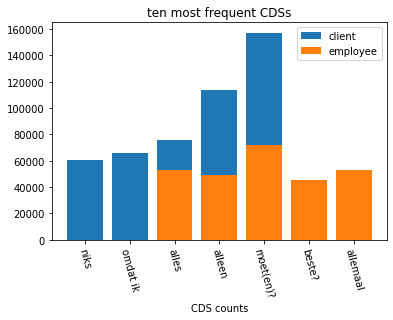

In [162]:
# comparison of the most frequent CDS used by employees vs clients
arg_sorted_client = np.argsort(all_sums_client.sum(axis =0),axis=0)
sorted_vals_client = np.sort(all_sums_client.sum(axis =0),axis=0)
arg_sorted_employee = np.argsort(all_sums_employee.sum(axis =0),axis=0)
sorted_vals_employee = np.sort(all_sums_employee.sum(axis =0),axis=0)

plt.figure()
plt.title("ten most frequent CDSs")
plt.bar([cds_names[index] for index in arg_sorted_client[-5:]],sorted_vals_client[-5:],label='client')
plt.bar([cds_names[index] for index in arg_sorted_employee[-5:]],sorted_vals_employee[-5:],label='employee')
plt.xlabel('CDS counts')
plt.xticks(rotation = -75)
plt.legend()

In [184]:
# some cds very poorly represented, i.e. they have less then 'min_sum' occurences in the 6719792 messages. Some cds must be disgarded
print('least frequent CDSs')
min_sum = 50
low_tresh_client = len(np.where(sorted_vals_client <= min_sum)[0])
low_thresh_employee = len(np.where(sorted_vals_employee <= min_sum)[0])
low_cds_client = arg_sorted_client[:low_tresh_client]
low_cds_employee = arg_sorted_employee[:low_thresh_employee]

common_cds_arg = [cds for cds in low_cds_client if cds in low_cds_employee]

common_cds=  [cds_names[index] for index in common_cds_arg]
print(common_cds) # cds to be disgarded
print(len(common_cds))

least frequent CDSs
['hij zal( .+ | )niet denken', 'w(ij|e) zullen( .+ | )weten', 'een onbekwa(am|me)', 'w(ij|e) zullen( .+ | )niet geloven', 'een niet geliefd', 'zwart-/wit', 'w(ij|e) zullen( .+ | )niet weten', 'w(ij|e) zullen( .+ | )niet denken', 'zal( .+ | )verkeerd gaan', 'j(ij|e) (zal|zult)( .+ | )niet weten', 'j(ij|e) (zal|zult)( .+ | )niet denken', 'zal onmogelijk zijn', '(zal|gaat) niet plaatsvinden', 'wordt vreselijk', 'zal vreselijk zijn', 'wordt verschrikkelijk', 'zal verschrikkelijk zijn', 'wordt een ramp', 'zal( .+ | )een ramp zijn', '(zal|gaat) nooit eindigen', 'we zullen( .+ | ) niet', 'j(ij|e) (zal|zult)( .+ | ) niet', 'w(ij|e) zullen( .+ | )geloven', 'z(ij|e) zullen( .+ | )niet denken', 'z(ij|e) zullen( .+ | ) niet', 'afdoende,? maar', 'iedereen zal( .+ | )geloven', 'hij zal( .+ | )niet geloven', 'hij zal( .+ | )geloven', 'ik zie slechts', 'hij zal( .+ | )niet weten', 'zal( .+ | )mis gaan', 'eindigt niet', 'acceptabel,? maar', 'z(ij|e) zal( .+ | )niet denken', 'alleen 

In [273]:
max_sums_client = np.argmax(all_sums_client,axis=1)
sums_sums_client = np.sum(all_sums_client,axis=1) 
max_sums_employee = np.argmax(all_sums_employee,axis=1)
sums_sums_employee = np.sum(all_sums_employee,axis=1)

df_employee = pd.DataFrame(data = {'max_time':max_sums_employee, 'sum':sums_sums_employee, 'bins':bins});
df_client = pd.DataFrame(data = {'max_time':max_sums_client, 'sum':sums_sums_client, 'bins':bins});

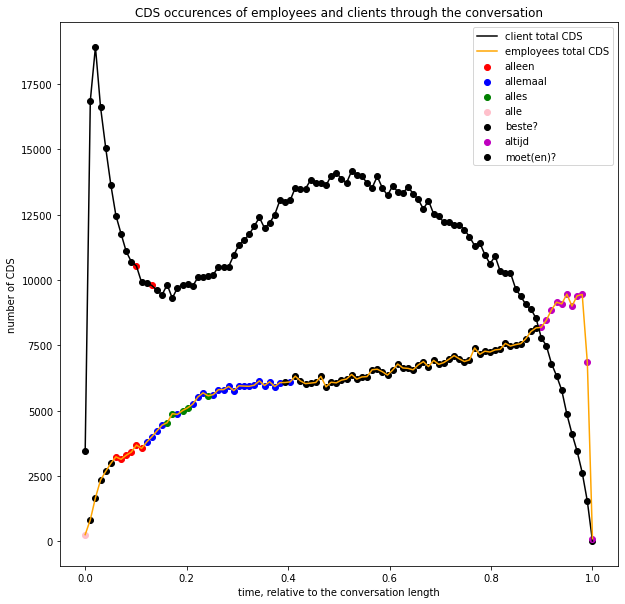

In [296]:
# printing the most frequent cds over time
unique_cds = np.unique(np.append(np.unique(max_sums_client),np.unique(max_sums_employee)))
cds_colors = dict(zip(unique_cds, ['red', 'blue','green','pink','black','m','black']))
plt.figure(figsize=(10,10))
plt.title("CDS occurences of employees and clients through the conversation")
plt.plot(bins, sums_sums_client, label='client total CDS',c='black')
for name, group in df_client.groupby("max_time"):
    plt.scatter(group['bins'],group['sum'],c=cds_colors[name])
plt.plot(bins, sums_sums_employee, label='employees total CDS',c='orange')

for name, group in df_employee.groupby("max_time"):
    plt.scatter(group['bins'],group['sum'],label=cds_names[name],c=cds_colors[name])
    
plt.xlabel('time, relative to the conversation length')
plt.ylabel('number of CDS')

plt.legend()

In [7]:
image_folder_path = "C:/Users/louis/github_vs/MA2---Towards-real-time-support-for-a-suicide-prevention-hotline-operators-"

df_all_prechat = pd.read_csv(image_folder_path+'/df_all_prechat.tsv', sep='\t')
df_all_prechat.drop(['id','sec_since_start'],axis=1,inplace=True)

In [11]:
# computing the correlations between cdss and states
states = ['negative','postive']

all_tops =[]

for i,state in enumerate(states):  
                        
    user_goups = df_all_prechat.groupby(['user_handle'])
    
    for name, user_group in user_goups:
            
        user_state = user_group[[state,'event_id']].groupby('event_id').max()
        user_group = user_group.drop(states,axis=1).groupby('event_id').sum()
        user_group[state] =user_state
        
        all_corrs =user_group.corr()[state][:-1].dropna()
        order = all_corrs.abs().sort_values(ascending=False).index
        all_corrs = all_corrs[order]

        print("The most correlated responses of",name,'in',state,"state are:")
        top = all_corrs.head(10)
        print(top)
        all_tops.append(top)
        print("-------------------------------------------------------")              


The most correlated responses of client in negative state are:
het (aller)?beste?          -0.106506
niemand                      0.096861
w(ij|e) weten               -0.092812
alles                        0.086353
w(ij|e) weten( .+ | )niet   -0.084635
w(ij|e) denken              -0.073321
niks                         0.072279
hij( .+ | )nooit            -0.064459
iedereen                     0.063515
z(ij|e) denkt               -0.058997
Name: negative, dtype: float64
-------------------------------------------------------
The most correlated responses of employee in negative state are:
hij( .+ | )altijd       -0.103620
z(ij|e)( .+ | )altijd   -0.088744
niet (één|een)          -0.086265
helemaal                 0.059394
hij denkt               -0.057574
z(ij|e) denkt           -0.055930
niemand                  0.054890
allemaal                 0.053485
moet(en)?                0.053327
altijd                  -0.046278
Name: negative, dtype: float64
----------------------------------

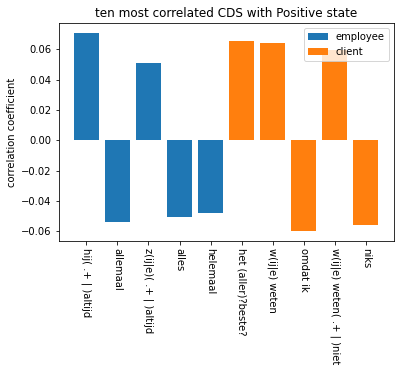

In [13]:
plt.figure()
plt.title("ten most correlated CDS with Positive state")

nb =5
plt.bar(all_tops[3][:nb].index,all_tops[3][:nb].values,label='employee')
plt.bar(all_tops[2][:nb].index,all_tops[2][:nb].values,label='client')
plt.ylabel('correlation coefficient')
plt.xticks(rotation = -90)
plt.legend()

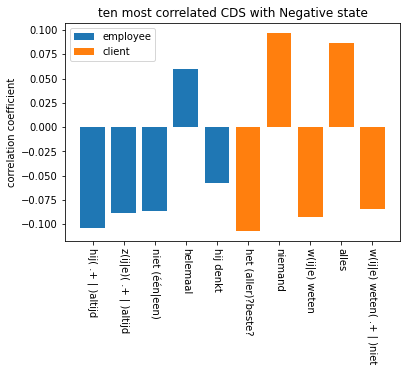

In [14]:
plt.figure()
plt.title("ten most correlated CDS with Negative state")

nb =5
plt.bar(all_tops[1][:nb].index,all_tops[1][:nb].values,label='employee')
plt.bar(all_tops[0][:nb].index,all_tops[0][:nb].values,label='client')
plt.ylabel('correlation coefficient')
plt.xticks(rotation = -90)
plt.legend()